# <div style="text-align:center">2023년 월간 데이콘 음성 감정 인식 AI 경진대회 <br/><데이터 분석 시작></div>

<div style="text-align: right"> <b>강남대학교 데이터사이언스전공 손민기</b></div>
<div style="text-align: right"> <b>강남대학교 데이터사이언스전공 김유성</b></div>
<div style="text-align: right"> <b>Email : sonmingi135@gmail.com</b></div>
<div style="text-align: right"> <b>Email : kimys5278@gmail.com</b></div>


# 음향 데이터를 분석하고 사람의 감정을 인식하는 AI 모델만들기

# Importing 작업

In [1]:
import matplotlib.pyplot as plt
import librosa #librosa는 오디오 신호를 처리하고 분석하는데 사용되는 파이썬 라이브러리입니다.
import librosa.display as dsp # librosa.display는 librosa에서 사용되는 그래픽 기능을 제공합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.tree import DecisionTreeClassifier

# 1. 데이터 확인

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_df.head()

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int16 
dtypes: int16(1), object(2)
memory usage: 88.0+ KB


In [3]:
train_df = pd.read_csv('./train.csv',
                        dtype={
                            'label':np.int16
                        })
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int16 
dtypes: int16(1), object(2)
memory usage: 88.0+ KB


> null 값 없음

In [5]:
label_count = train_df.label.value_counts()
label_count=label_count.sort_values(ascending=False)
label_count

label
0    867
2    859
5    853
3    852
1    848
4    722
Name: count, dtype: int64

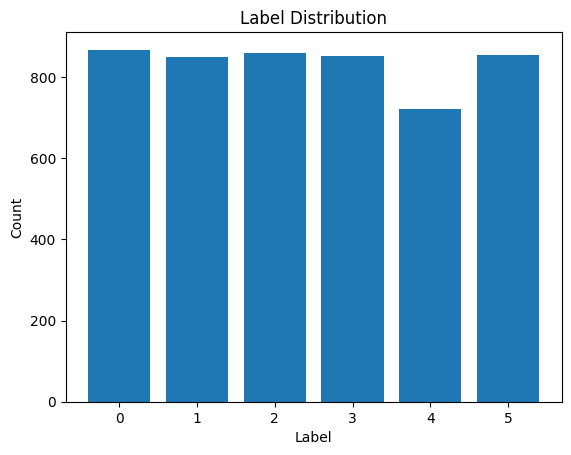

In [6]:
plt.bar(label_count.index, label_count.values, edgecolor='none')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

>label별 value_counts 생성.<br>
>4 label을 제외 하고 대부분 비슷한 count를 가짐.

## wav 파일 길이 비교

# 2. 음성 데이터 특징 추출(MFCC)
> 음성 데이터를 학습하기 위해서는 시계열 및 아날로그 데이터인 음성 데이터를 디지털 신호로 변환해야 한다.
<br>
이런식으로<br>
<hr>
<img src = /Users/sonmingi/Desktop/강남대학교/파이썬데이터분석/PY_PT/Son_PT/2023-05-29-20-26-30.png>


In [26]:
from tqdm import tqdm

len_list = []

for i in tqdm(train_df.id):
    y, s = librosa.load('./train/' + i + '.wav')
    len_list.append(len(y)/s)

100%|██████████| 5001/5001 [00:06<00:00, 764.38it/s]


<Axes: title={'center': 'Length of audio'}, ylabel='Density'>

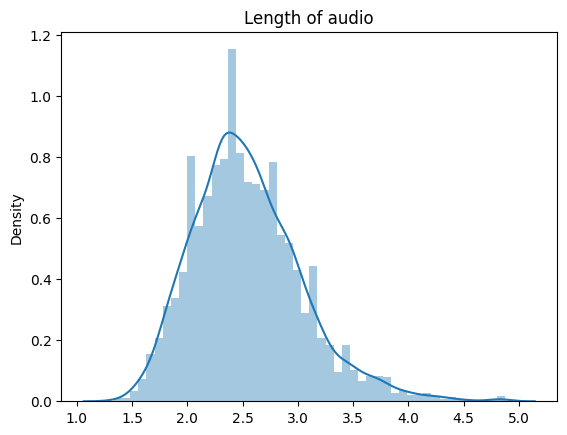

In [27]:
plt.title("Length of audio")
sns.distplot(len_list)

> 전체 wav 파일 load하여 길이 시각화 시 2.5초가 가장 많음.

> TRAIN_0000.wav 파일로 시각화(label : 1)

In [28]:
DATA_DIR = './train/'
wav ,sr = librosa.load(DATA_DIR + 'TRAIN_0000.wav', sr = 16000)
print('sr:',  sr) # sr = 초당 샘플 수
print(wav) # wav = 오디오 신호를 디지털 형식으로 나타내는 진폭 값의 배열.
print('wav shape', wav.shape)
print('length : ', wav.shape[0] / float(sr), 'secs') # 총 진폭 수에서 초당 샘플링 수를 나누면 길이 나옴.

sr: 16000
[0.00750732 0.00820923 0.00793457 ... 0.         0.         0.        ]
wav shape (37904,)
length :  2.369 secs


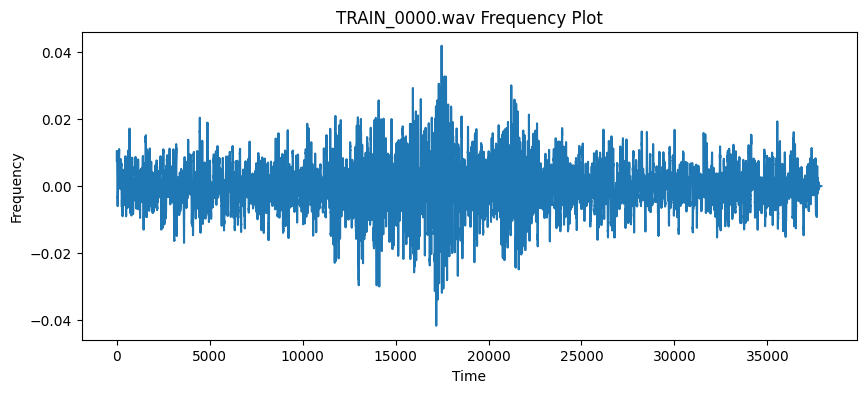

In [29]:
# raw wave
plt.figure(figsize=(10,4))
plt.plot(wav)
plt.title('TRAIN_0000.wav Frequency Plot')
plt.xlabel('Time')
plt.ylabel("Frequency")
plt.show()

# 푸리에 변환이란?
![Alt text](Audio%20Processing-1.jpg)

## 음성 데이터에 대한 이해
사람은 음성을 인식할 때 달팽이 관을 통해 음성을 인식한다. 달팽이 관 내부를 보면 아래 그림과 같이 각 부분에서 각기 다른 주파수(진동수)를 감지한다.<br>
그렇기 때문에 데이터 분석 시 주파수를 feature로 사용하는 것이다.<br>
![Alt text](2023-05-29-21-50-45.png)
<hr>

## 달팽이관의 특성
- 주파수가 낮은 대역에서는 주파수 변화를 잘 감지하지만, 높은 주파수 대역에서는 주파수 변화를 잘 감지하지 못한다.
    - ex) 실제로 2000Hz -> 3000Hz는 기가막히게 감지, But 12000Hz -> 13000Hz로 변하는 소리는 잘 감지 못함.
- "안녕하세요"라고 하였을 때 누구는 1초, 누구는 3초로 말 할 수 있음.
    - 이 문제를 해결하려면 음성데이터를 모두 20~40ms로 쪼갬. (20~40ms 사이에선 음소가 바뀔 수 없다는 연구결과를 기반)
- 위 2개의 특성을 고려하여 MFCC에서는 음성데이터를 모두 20~40ms 단위로 쪼개고, 쪼갠 단위에 대해서 Feature로 사용할 것이다.
<hr>

## MFCC (Mel Frequency Cepstral Coefficien) 추출 과정
![Alt text](2023-05-29-21-57-04.png)<br>
1. Pre-Emphasis : 사람이 발성 시 몸의 구조로 고주파 성분이 많이 줄어 나와, 고주파 성분을 변조가 강하게 걸리도록 하는 과정
2. Sampling and Windowing : 20~40ms로 프레임 분할(50%는 겹치게 분할해야함.) 그리고 이 각 프레임에 Window(음성의 길이를 얼마만큼으로 자를까?)를 적용(보통 Hamming Window 많이 사용.)
3. Fast Fourier Tranform : 각 프레임에 대하여 Fourier Transform을 통하여 주파수 성분을 얻어낸다.<br>
**사실 여기까지만 진행해도 충분한 학습 가능한 feature를 뽑을 수 있지만 사람 몸의 구조를 고려한 Mel-Scale을 적용한 feature가 보통 더 나은 성능을 가짐**
4. 각 프레임에 대해 나온 주파수 성분에 대하여 Mel값을 얻어내기 위한 Filter를 적용<br>
![Alt text](2023-05-29-22-09-10.png)<br>
> 고주파 대역으로 갈수록 넓은 삼각형 Filter 가짐. Frequency에 삼각형 필터 N개를 모두 적용한 Filter를 Mel-Filter-Bank라고 부름.<br>
Mel-Filter-Bank 를 모두 거쳐 나오면 Mel-Spectrogram이 나오게 됨.
![Alt text](2023-05-29-22-13-27.png)<br>
5. Mel-Spectrogram feature에 대해 행렬을 압축해서 표현해주는 DCT 연산을 수행. 이 Output이 바로 MFCC임.

In [30]:
# load 후에 음성 데이터의 특징 추출.
wav, sr = librosa.load(DATA_DIR + 'TRAIN_0000.wav', sr=16000)

In [31]:
frame_length = 0.025 # window 길이
frame_stride = 0.010 # hop_length

def Mel_S(wav_file):
    wav, sr = librosa.load(wav_file, sr=16000)
    input_nfft = int(round(sr * frame_length))
    input_stride = int(round(sr * frame_stride))
    S = librosa.feature.melspectrogram(y=wav, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    print("Wav length: {}, Mel_S shape: {}".format(len(wav) / sr, np.shape(S)))

Mel_S(DATA_DIR + 'TRAIN_0000.wav')


Wav length: 2.369, Mel_S shape: (40, 237)


> 총 길이는 2.37초이고, frame_stride를 0.01로 설정하여 약 237 window 로 나뉜것을 도출.

# mfcc() parameter
- sr : default = 22050Hz이다. 앞서 load할 때 sr을 16000으로 설정 하여서 맞춰줘야함.
- n_mfcc : return 될 mfcc 개수 정해주는 parameter, default = 20
- n_fft : frame의 length를 결정하는 parameter, n_fft를 설정하면 window size도 동일한 값으로 설정됨. 
- hop_length : 음성의 frame을 얼만큼 겹친 상태로 잘라서 칸을 보여줄 것인가?

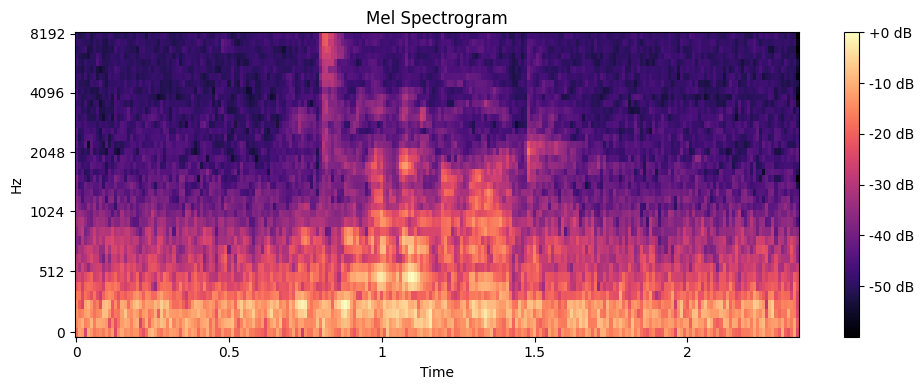

In [16]:
# melspectrogram plot으로 보기
frame_length = 0.025 # window 길이
frame_stride = 0.010 # hop_length

def Draw_Mel_S(wav_file):
    wav, sr = librosa.load(wav_file, sr=16000)
    input_nfft = int(round(sr * frame_length))
    input_stride = int(round(sr * frame_stride))
    S = librosa.feature.melspectrogram(y=wav, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref = np.max),
    y_axis = 'mel', sr = sr, hop_length = input_stride, x_axis = 'time')
    plt.colorbar(format = '%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
Draw_Mel_S(DATA_DIR+'TRAIN_0000.wav')

![Alt text](2023-05-30-01-50-06.png)

## Decision Tree로 분류모델 구현

In [33]:
def get_mel_feature(df):
    features = []
    for path in tqdm(df['path']):
        wav, sr = librosa.load(path,sr=16000)
        input_nfft = int(round(sr * frame_length))
        input_stride = int(round(sr * frame_stride))
        S = librosa.feature.melspectrogram(y=wav, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
        # 기존 방법 그대로 feature 추출
        y_feature = []
        # 추출된 Mel-F들의 평균 사용
        for e in S:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    Mel_DF = pd.DataFrame(features, columns=['mel_f'+str(x)for x in range(1,41)])
    return Mel_DF

In [34]:
train_x = get_mel_feature(train_df)
test_x = get_mel_feature(test_df)

100%|██████████| 1881/1881 [00:03<00:00, 585.50it/s]


In [35]:
train_y = train_df['label']

In [37]:
model = DecisionTreeClassifier(random_state=42)
model.fit(train_x,train_y)

DecisionTreeClassifier(random_state=42)

In [38]:
preds = model.predict(test_x)

In [39]:
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./baseline_submission.csv',index=False)